# GeoSPARQL Examples

In the following tutorial we will show how to ETL geometric data into an AllegroGraph repository, and then demonstrate a few GeoSPARQL queries. This notebook is not meant to be an exhaustive list of every possible SPARQL GeoSPARQL function, but to show the patterns that all subsequent functions follow. There are many more functions available within the Franz SPARQL engine than we will show, and more can be found [here](https://opengeospatial.github.io/ogc-geosparql/geosparql11/geo.ttl).

We start by importing `geopandas` and some utility functions from the agraph-python `franz` package, and connecting to a new repository. Make sure to add your own connection parameters:

In [1]:
import geopandas as gpd

from franz.openrdf.connect import ag_connect
from franz.openrdf.vocabulary import RDF, RDFS

import json
import shortuuid
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt

#the repository connection. Please add your connection parameters here
#conn = ag_connect('geosparql-examples', clear=True,
#                   host='localhost', port='10035',
#                   user='your AllegroGraph username', password='your AllegroGraph password')

# 8.4.0
#the repository connection. Please add your connection parameters here
conn = ag_connect('geosparql-examples', clear=True,
                   host='demo2.franz.com', port='10079',
                   user='hans', password='HTmVfzwFAJLoW9ba-X2MF4E.G2NE')

#8.2.0
#conn = ag_connect('geosparql-examples', clear=True,
#                   host='demo2.franz.com', port='10079',
#                   user='test', password='xyzzy')


#defining namespaces
geo = conn.namespace('http://www.opengis.net/ont/geosparql#')
conn.setNamespace('geo', 'http://www.opengis.net/ont/geosparql#')

uri = 'http://franz.com/'
f = conn.namespace(uri)
conn.setNamespace('f', uri)

## ETL

Now we read in some data that contains various geometric objects. We will look at Provinces and Municipalities in the Netherlands (and make some simple plots of the data). If you are interested you can download more data here at [https://gadm.org/download_country.html](https://gadm.org/download_country.html). Importing a file with `geopandas` makes it so that the geometry data is correctly added in the dataframe.

In [2]:
df_province = gpd.read_file('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_NLD_1.json.zip')
df_province.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,NLD.1_1,NLD,Netherlands,Drenthe,NA,NA,Provincie,Province,NA,NL.DR,NL-DR,"MULTIPOLYGON (((6.52370 52.64550, 6.52740 52.6..."
1,NLD.2_1,NLD,Netherlands,Flevoland,NA,NA,Provincie,Province,NA,NL.FL,NL-FL,"MULTIPOLYGON (((5.30390 52.31250, 5.24500 52.3..."
2,NLD.3_1,NLD,Netherlands,Fryslân,Friesland,NA,Provincie,Province,NA,NL.FR,NL-FR,"MULTIPOLYGON (((6.23920 52.91320, 6.21490 52.8..."
3,NLD.4_1,NLD,Netherlands,Gelderland,Geldern|Gheldria|Guelders|Gueldr,NA,Provincie,Province,NA,NL.GE,NL-GE,"MULTIPOLYGON (((5.13580 51.73850, 5.13140 51.7..."
4,NLD.5_1,NLD,Netherlands,Groningen,Groninga|Groningue,NA,Provincie,Province,NA,NL.GR,NL-GR,"MULTIPOLYGON (((6.91710 53.01160, 6.74680 53.1..."


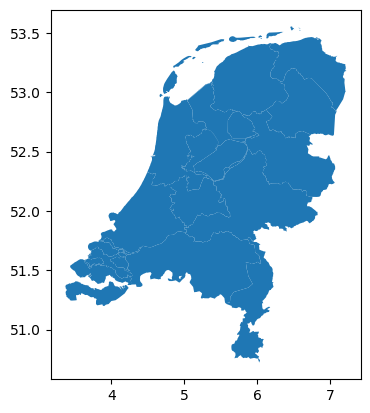

In [3]:
df_province.plot()
plt.show()

As you can see, the last column named `geometry` contains a number of **Multipolygons**.

Before we are able to ETL the data into our repository, we need to define a function that converts each entry in the `geometry` column into a **MultiPolygon  geo:geoJSONLiteral**. You can read more about the shapes of these [here](https://datatracker.ietf.org/doc/html/rfc7946#section-3.1.7):


In [4]:
def convert_geo_to_literal(geometry_cell):
    _json = {"type": "MultiPolygon", "coordinates": []}
    for geom in geometry_cell.geoms:
        multi = []
        for point in geom.exterior.coords:
            coordinates = [point[0], point[1]]
            multi.append(coordinates)
        _json["coordinates"].append([multi])
    json_string = json.dumps(_json)
    return conn.createLiteral(json_string, datatype=geo.geoJSONLiteral)

We will do a very simplified version of the ETL. We could add more metadata about each province, but for now we will only gather the names and rdf:types of each geometric feature (a `geo:Feature` being the object we care about, in this case a province). The most important thing is that you need to create an object with `rdf:type` `geo:Feature`, and also create another objects with `rdf:type` `geo:Geometry`. Then that geometry object has the geometric data attached as a literal.

In [5]:
triples = []
for i in range(df_province.shape[0]):
    province_uri = conn.createURI(f"{uri}{df_province['GID_1'][i]}")
    triples.append((province_uri, RDF.TYPE, conn.createURI(f"{uri}{df_province['ENGTYPE_1'][i]}")))
    triples.append((province_uri, RDF.TYPE, geo.Feature))

    #add name info and a label
    triples.append((province_uri, RDFS.LABEL, df_province['NAME_1'][i]))
    triples.append((province_uri, f.provinceName, df_province['NAME_1'][i]))

    #add geometry
    geo_uri = conn.createURI(f"{uri}{shortuuid.uuid()}")
    triples.append((geo_uri, RDF.TYPE, geo.Geometry))
    triples.append((province_uri, geo.hasGeometry, geo_uri))
    geometry_literal = convert_geo_to_literal(df_province['geometry'][i])
    triples.append((geo_uri, geo.asGeoJSON, geometry_literal))
    
conn.addTriples(triples)
conn.deleteDuplicates(mode='spo')

Now we will also ETL some more Netherlands Municipality Data

In [6]:
df_muni = gpd.read_file('https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_NLD_2.json.zip')
df_muni.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,NLD.1.1_1,NLD,Netherlands,NLD.1_1,Drenthe,NA,AaenHunze,NA,NA,Gemeente,Municipality,NA,NL.DR.AH,"MULTIPOLYGON (((6.56990 52.94650, 6.58990 52.9..."
1,NLD.1.2_1,NLD,Netherlands,NLD.1_1,Drenthe,NA,Assen,NA,NA,Gemeente,Municipality,NA,NL.DR.AS,"MULTIPOLYGON (((6.64080 53.02570, 6.63920 53.0..."
2,NLD.1.3_1,NLD,Netherlands,NLD.1_1,Drenthe,NA,Borger-Odoorn,NA,NA,Gemeente,Municipality,NA,NL.DR.BO,"MULTIPOLYGON (((6.74570 52.87920, 6.73630 52.9..."
3,NLD.1.4_1,NLD,Netherlands,NLD.1_1,Drenthe,NA,Coevorden,NA,NA,Gemeente,Municipality,NA,NL.DR.CO,"MULTIPOLYGON (((6.87160 52.65300, 6.86450 52.6..."
4,NLD.1.5_1,NLD,Netherlands,NLD.1_1,Drenthe,NA,DeWolden,NA,NA,Gemeente,Municipality,NA,NL.DR.DW,"MULTIPOLYGON (((6.27320 52.66810, 6.27640 52.6..."


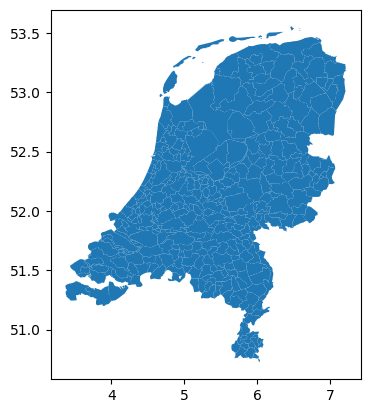

In [7]:
df_muni.plot()
plt.show()

We will skip bodies of water for simplicity's sake

In [8]:
triples = []
for i in range(df_muni.shape[0]):
    if df_muni['ENGTYPE_2'][i] != 'Waterbody':
        muni_uri = conn.createURI(f"{uri}{df_muni['GID_2'][i]}")
        triples.append((muni_uri, RDF.TYPE, conn.createURI(f"{uri}{df_muni['ENGTYPE_2'][i]}")))
        triples.append((muni_uri, RDF.TYPE, geo.Feature))

        #get name info
        triples.append((muni_uri, RDFS.LABEL, df_muni['NAME_2'][i]))
        triples.append((muni_uri, f.municipalityName, df_muni['NAME_2'][i]))

        #link to provinces
        province_uri = conn.createURI(f"{uri}{df_muni['GID_1'][i]}")
        triples.append((province_uri, f.municipality, muni_uri))

        #add geometry
        geo_uri = conn.createURI(f"{uri}{shortuuid.uuid()}")
        triples.append((geo_uri, RDF.TYPE, geo.Geometry))
        triples.append((muni_uri, geo.hasGeometry, geo_uri))
        geometry_literal = convert_geo_to_literal(df_muni['geometry'][i])
        triples.append((geo_uri, geo.asGeoJSON, geometry_literal))
conn.addTriples(triples)
conn.deleteDuplicates(mode='spo')

We can examine the data in Gruff. Notice that the Provinces and Municipalities all have related `geometry` objects and to that we connect the **Multipolygon** literal

![sample layout](img/geosparql-etl-layout.png)

## The format of GeoSPARQL queries

GeoSPARQL queries do comparisons and calculations between different geometries. Those can be points, lines, polygons and others. However, most queries will follow the following format.

```
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>

SELECT ?result WHERE {
    ?feature1 a geo:Feature ;
              geo:hasGeometry ?geometry1 .
    ?geometry1 a geo:Geometry ;
              geo:asGeoJSON ?geoJSON1 .
              
    ?feature2 a geo:Feature ;
              geo:hasGeometry ?geometry2 .
    ?geometry2 a geo:Geometry ;
              geo:asGeoJSON ?geoJSON2 .
              
    BIND ( geof:sfWithin(?geometry1, ?geometry2) as ?result ) .
```

Instead of `geof:sfWithin` can be replaced by many of the geospatial functions.

## The **S** imple **F** eatures functions: 

As defined by Simple Features [[OGCSFACA]](https://opengeospatial.github.io/ogc-geosparql/geosparql11/spec.html#OGCSFACA) [[ISO19125-1]](https://opengeospatial.github.io/ogc-geosparql/geosparql11/spec.html#ISO19125-1), AllegroGraph supports `geof:sfEquals`, `geof:sfDisjoint`, `geof:sfIntersects`, `geof:sfTouches`, `geof:sfCrosses`, `geof:sfWithin`, `geof:sfContains` and `geof:sfOverlaps` as SPARQL extension functions, consistent with their corresponding DE-9IM intersection patterns, where geof: namespace has uri http://www.opengis.net/def/function/geosparql/. Here are a few examples of those:


## sfWithin / sfContains

In the following example we find which municipality a given point is within.

As a note, `sfWithin` is the inverse of `sfContains`. The key difference is directionality
* `sfWithin` is used when you want to check if one geometry is completely inside another.
* `sfContains` is used when you want to check if one geometry completely encompasses another.

In [9]:
%%time
query_string = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>

SELECT ?label  WHERE {
  BIND ( 'POINT(4.9041 52.3676)'^^geo:wktLiteral  as ?point) #The point
  ?municipality geo:hasGeometry ?geometry ;
                a f:Municipality ;
                rdfs:label ?label .
  ?geometry geo:asGeoJSON ?geoJsonLiteral .
  BIND ( geof:sfWithin( ?point, ?geoJsonLiteral ) as ?result ) #the function
  FILTER ( ?result = "true"^^xsd:boolean ) . }"""
result = conn.executeTupleQuery(query_string).toPandas()
result.head()

CPU times: user 6.37 ms, sys: 154 μs, total: 6.52 ms
Wall time: 130 ms


,label
0,Amsterdam


We will plot to show where the point lies

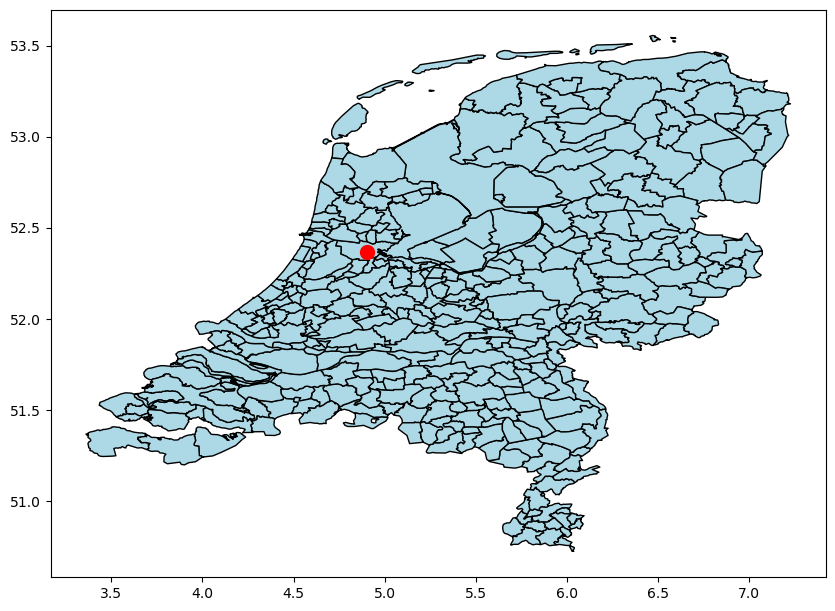

In [36]:
from shapely.geometry import Point
from shapely import wkt

point_wkt = 'POINT(4.9041 52.3676)'  # Amsterdam coordinates
point = wkt.loads(point_wkt)
gdf_point = gpd.GeoSeries([point])
ax = df_muni.plot(color='lightblue', edgecolor='black', figsize=(10, 10))
gdf_point.plot(ax=ax, color='red', marker='o', markersize=100)

# Display the plot
plt.show()

## sfIntersects

We find which Provinces a certain line intersects. The line starts at the top of the netherlands and ends at the bottom.

In [24]:
%%time
query_string = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>

SELECT ?label  WHERE {
  BIND ( '''{
              "type": "LineString",
              "coordinates": [
                    [6.074182, 53.510403],  
                    [5.887200, 50.750383] 
                ] }'''^^geo:geoJSONLiteral  as ?line )
  ?province geo:hasGeometry ?geometry ;
                a f:Province ;
                rdfs:label ?label .
  ?geometry geo:asGeoJSON ?geoJsonLiteral .
  BIND ( geof:sfIntersects(?line, ?geoJsonLiteral ) as ?result )
  FILTER ( ?result = "true"^^xsd:boolean ) . }"""
result = conn.executeTupleQuery(query_string).toPandas()
result.head()

CPU times: user 6.03 ms, sys: 3.6 ms, total: 9.63 ms
Wall time: 49.8 ms


,label
0,Overijssel
1,Noord-Brabant
2,Limburg
3,Gelderland
4,Fryslân


We will prove by plotting the line over the multipolygons

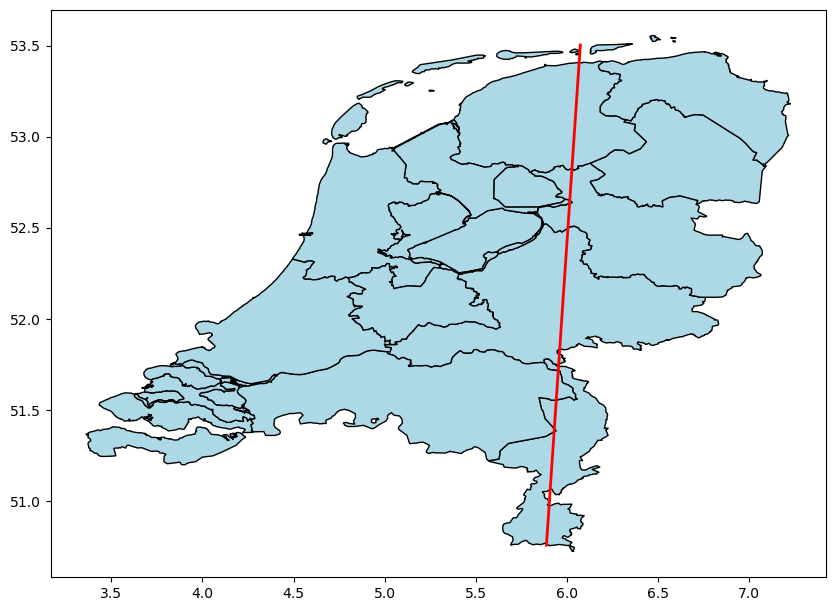

In [38]:
from shapely.geometry import LineString

line = LineString([
    [6.074182, 53.510403],  # Top of the Netherlands
    [5.887200, 50.750383]   # Bottom of the Netherlands
])

gdf_line = gpd.GeoSeries([line])
ax = df_province.plot(color='lightblue', edgecolor='black', figsize=(10, 10))
gdf_line.plot(ax=ax, color='red', linewidth=2)
plt.show()

### Distance

We start by computing the shortest **distance** between two geometries. In this example we will compute the **distance** between 'Amsterdam' and 'Groningen' in kilometers. Notice the `qudt` prefix for units of measurement. You can read more about that [here](https://qudt.org/2.1/vocab/unit)

In [26]:
%%time
query_string = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX qudt: <http://qudt.org/vocab/unit/>

SELECT (geof:distance(?amsterdamGeoLit, ?groningenGeoLit, qudt:KiloM) as ?distance) WHERE {
    #amsterdam
    ?amsterdam f:municipalityName "Amsterdam" ;
               geo:hasGeometry ?amsterdamGeo .
    ?amsterdamGeo geo:asGeoJSON ?amsterdamGeoLit .

    #Gronginen
    ?groningen f:municipalityName "Groningen" ;
               geo:hasGeometry ?groningenGeo .
    ?groningenGeo geo:asGeoJSON ?groningenGeoLit . }"""
result = conn.executeTupleQuery(query_string).toPandas()
result.head()

CPU times: user 3.03 ms, sys: 3.65 ms, total: 6.68 ms
Wall time: 15.1 ms


,distance
0,128.477003


## Intersection

In the following query we show that there is an intersection between 'Amsterdam' and the province it is in 'Noord-Holland'. Since 'Amsterdam' is in 'Noord-Holland' it makes sense that we get a full **Multipolygon** as a result.

In [27]:
%%time
query_string = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>

SELECT (geof:intersection(?amsterdamGeoLit, ?nhGeoLit) as ?intersection) WHERE {
    #amsterdam
    ?amsterdam f:municipalityName "Amsterdam" ;
               geo:hasGeometry ?amsterdamGeo .
    ?amsterdamGeo geo:asGeoJSON ?amsterdamGeoLit .

    #Noord-Holland
    ?nh f:provinceName "Noord-Holland" ;
               geo:hasGeometry ?nhGeo .
    ?nhGeo geo:asGeoJSON ?nhGeoLit . }"""
result = conn.executeTupleQuery(query_string).toPandas()
pprint(result['intersection'][0])

('MULTIPOLYGON (((5.0257 52.3028, 5.0154 52.3037, 5.0066 52.2982, 5.0052 '
 '52.2928, 5.0009 52.2892, 4.9876 52.2901, 4.973 52.282, 4.9715 52.2793, '
 '4.9579430623426655 52.27870349474308, 4.933 52.3069, 4.9329 52.3087, 4.9446 '
 '52.3186, 4.9401 52.3231, 4.9503 52.3277, 4.9563 52.3223, 4.9813 52.3314, '
 '4.9886 52.3305, 4.9931 52.3278, 5.0005 52.318, 5.0007 52.3144, 5.0199 '
 '52.3242, 5.0257 52.3028)), ((4.9883 52.3601, 4.9809 52.3637, 4.9824 52.3646, '
 '4.9898 52.361, 4.9957 52.3619, 5.009 52.3548, 5.0105 52.3503, 5.0008 '
 '52.3494, 4.9898 52.3566, 4.9883 52.3601)), ((5.0557 52.4133, 5.0498 52.407, '
 '5.0351 52.4007, 5.0322 52.398, 5.0293 52.389, 5.0161 52.3835, 5.0176 '
 '52.3791, 5.0147 52.3737, 5.0118 52.3728, 5.0044 52.3745, 5.0014 52.379, '
 '4.9838 52.3735, 4.9778 52.3789, 4.9674 52.3834, 4.9616 52.3806, 4.9646 '
 '52.378, 4.9838 52.3691, 4.9794 52.3655, 4.9721 52.3654, 4.972 52.3681, '
 '4.9617 52.3681, 4.9617 52.3654, 4.978 52.3583, 4.9854 52.3574, 5.0004 '
 '52.3491, 5

## Union

Here we run a query that returns a **Multipolygon** of the *union* of the two geometries. Since these two are not connected it should return the two multipolygons of each, as one multipolygon.

In [28]:
%%time
query_string = """
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX uom: <http://www.opengis.net/def/uom/OGC/1.0/>

SELECT (geof:union(?amsterdamGeoLit, ?groningenGeoLit) as ?union) WHERE {
    #amsterdam
    ?amsterdam f:municipalityName "Amsterdam" ;
               geo:hasGeometry ?amsterdamGeo .
    ?amsterdamGeo geo:asGeoJSON ?amsterdamGeoLit .

    #Gronginen
    ?groningen f:municipalityName "Groningen" ;
               geo:hasGeometry ?groningenGeo .
    ?groningenGeo geo:asGeoJSON ?groningenGeoLit . }"""
result = conn.executeTupleQuery(query_string).toPandas()
pprint(result['union'][0])

('MULTIPOLYGON (((5.0199 52.3242, 5.0257 52.3028, 5.0154 52.3037, 5.0066 '
 '52.2982, 5.0052 52.2928, 5.0009 52.2892, 4.9876 52.2901, 4.973 52.282, '
 '4.9715 52.2793, 4.9583 52.2783, 4.933 52.3069, 4.9329 52.3087, 4.9446 '
 '52.3186, 4.9401 52.3231, 4.9503 52.3277, 4.9563 52.3223, 4.9813 52.3314, '
 '4.9886 52.3305, 4.9931 52.3278, 5.0005 52.318, 5.0007 52.3144, 5.0199 '
 '52.3242)), ((4.9898 52.3566, 4.9883 52.3601, 4.9809 52.3637, 4.9824 52.3646, '
 '4.9898 52.361, 4.9957 52.3619, 5.009 52.3548, 5.0105 52.3503, 5.0008 '
 '52.3494, 4.9898 52.3566)), ((5.066 52.4138, 5.0557 52.4133, 5.0498 52.407, '
 '5.0351 52.4007, 5.0322 52.398, 5.0293 52.389, 5.0161 52.3835, 5.0176 '
 '52.3791, 5.0147 52.3737, 5.0118 52.3728, 5.0044 52.3745, 5.0014 52.379, '
 '4.9838 52.3735, 4.9778 52.3789, 4.9674 52.3834, 4.9616 52.3806, 4.9646 '
 '52.378, 4.9838 52.3691, 4.9794 52.3655, 4.9721 52.3654, 4.972 52.3681, '
 '4.9617 52.3681, 4.9617 52.3654, 4.978 52.3583, 4.9854 52.3574, 5.0004 '
 '52.3491, 5.0047 5

# GeoHashing

On top of the standard GeoSPARQL functions, AllegroGraph adds a few useful extensions. In this section, the prefix `geoext:` stands for the namespace `http://franz.com/ns/allegrograph/3.0/geosparql/ext#`.

## Geohash Indexing

[Geohash](https://en.wikipedia.org/wiki/Geohash) is an algorithm that encodes a geographic location into a short string of letters and digits. For example, [latitude: 37.88963389303175, longitude: -122.12956214302625](https://goo.gl/maps/ejrUhFSrJc8zRuadA) may be encoded as `"9q9psceun6"`. To provide better spatial query performance, we have implemented Geohash indexing, which is a critical component required by a few other extensions.

To index your spatial geometries, use either `geoext:buildGeohashIndex` or `geoext:rebuildGeohashIndex` [SPARQL magic property](https://franz.com/agraph/support/documentation/current/magic-properties.html).

For a more detailed description please look at [section 3 of our geosparql-tutorial](geosparql-tutorial.ipynb).

We start by build a `geohash index` of our existing gei data.

In [10]:
conn.prepareTupleQuery(query="""
PREFIX geoext: <http://franz.com/ns/allegrograph/3.0/geosparql/ext#>

SELECT ?success WHERE {
    ?success geoext:buildGeohashIndex () .
}
""").evaluate().toPandas()

,success
0,True


Now we use the `geo` namespace as a magic predicate to search for which municipalities are within which provinces. In a larger dataset this version will be much faster than the non-geohashed version. 

In [15]:
%%time
query_string = """
PREFIX franzOption_clauseReorderer: <franz:identity> 
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX geof: <http://www.opengis.net/def/function/geosparql/>

select ?provinceLabel ?muniLabel where {
    ?province geo:hasGeometry ?provinceGeo ;
                a f:Province ; rdfs:label ?provinceLabel . 
    <http://franz.com/NLD.11.31_1>  geo:hasGeometry ?muniGeo ;
                rdfs:label ?muniLabel .
    ?muniGeo geo:sfWithin ?provinceGeo . }
"""
result = conn.executeTupleQuery(query_string).toPandas()
print(result.shape)
result.head()

(1, 2)
CPU times: user 5.65 ms, sys: 1.46 ms, total: 7.11 ms
Wall time: 17.7 ms


,provinceLabel,muniLabel
0,Utrecht,Woerden
